# Loop 10 LB Feedback Analysis

## Critical Finding: exp_009 ([16]) LB is WORSE than exp_007 ([32,16])!

| Experiment | CV Score | LB Score | CV-LB Gap |
|------------|----------|----------|----------|
| exp_007 ([32,16]) | 0.009262 | 0.0932 | -0.0839 |
| exp_009 ([16]) | 0.009192 | 0.0936 | -0.0844 |

**Despite better CV, [16] has WORSE LB!**

This confirms the evaluator's concern about the increasing CV-LB ratio.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Complete submission history
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982, 'arch': '[128,128,64]'},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065, 'arch': 'LightGBM'},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972, 'arch': '[256,128,64]'},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969, 'arch': '[256,128,64] 15-bag'},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946, 'arch': '[64,32]'},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932, 'arch': '[32,16]'},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936, 'arch': '[16]'},  # NEW!
]

df = pd.DataFrame(submissions)
df['ratio'] = df['lb'] / df['cv']
df['gap'] = df['lb'] - df['cv']
print('=== Complete Submission History ===')
print(df.to_string())

=== Complete Submission History ===
       exp      cv      lb                 arch      ratio     gap
0  exp_000  0.0111  0.0982         [128,128,64]   8.846847  0.0871
1  exp_001  0.0123  0.1065             LightGBM   8.658537  0.0942
2  exp_003  0.0105  0.0972         [256,128,64]   9.257143  0.0867
3  exp_005  0.0104  0.0969  [256,128,64] 15-bag   9.317308  0.0865
4  exp_006  0.0097  0.0946              [64,32]   9.752577  0.0849
5  exp_007  0.0093  0.0932              [32,16]  10.021505  0.0839
6  exp_009  0.0092  0.0936                 [16]  10.173913  0.0844


In [2]:
# Analyze the CV-LB relationship with the new data point
print('\n=== CV-LB Relationship Analysis (Updated) ===')
print(f'\nCorrelation between CV and LB: {df["cv"].corr(df["lb"]):.4f}')

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])
print(f'\nLinear fit: LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'R-squared: {r_value**2:.4f}')

# Check if [16] is an outlier
df['predicted_lb'] = slope * df['cv'] + intercept
df['residual'] = df['lb'] - df['predicted_lb']
print('\n=== Residual Analysis ===')
print(df[['exp', 'arch', 'cv', 'lb', 'predicted_lb', 'residual']].to_string())


=== CV-LB Relationship Analysis (Updated) ===

Correlation between CV and LB: 0.9675

Linear fit: LB = 3.9935 * CV + 0.0558
R-squared: 0.9361

=== Residual Analysis ===
       exp                 arch      cv      lb  predicted_lb  residual
0  exp_000         [128,128,64]  0.0111  0.0982      0.100138 -0.001938
1  exp_001             LightGBM  0.0123  0.1065      0.104930  0.001570
2  exp_003         [256,128,64]  0.0105  0.0972      0.097742 -0.000542
3  exp_005  [256,128,64] 15-bag  0.0104  0.0969      0.097343 -0.000443
4  exp_006              [64,32]  0.0097  0.0946      0.094547  0.000053
5  exp_007              [32,16]  0.0093  0.0932      0.092950  0.000250
6  exp_009                 [16]  0.0092  0.0936      0.092550  0.001050


In [3]:
# Key insight: The [16] model has POSITIVE residual (worse than predicted)
print('\n=== KEY INSIGHT ===')
print('The [16] model has a POSITIVE residual, meaning it performed WORSE on LB than predicted.')
print('This suggests the model is overfitting to the CV structure.')

# Compare [32,16] vs [16]
print('\n=== [32,16] vs [16] Comparison ===')
print(f'[32,16]: CV {0.0093:.4f}, LB {0.0932:.4f}, Ratio {0.0932/0.0093:.2f}x')
print(f'[16]:    CV {0.0092:.4f}, LB {0.0936:.4f}, Ratio {0.0936/0.0092:.2f}x')
print(f'\nCV improvement: {(0.0093-0.0092)/0.0093*100:.2f}%')
print(f'LB degradation: {(0.0936-0.0932)/0.0932*100:.2f}%')
print('\n[16] is OVERFITTING to CV! The simpler model generalizes worse.')


=== KEY INSIGHT ===
The [16] model has a POSITIVE residual, meaning it performed WORSE on LB than predicted.
This suggests the model is overfitting to the CV structure.

=== [32,16] vs [16] Comparison ===
[32,16]: CV 0.0093, LB 0.0932, Ratio 10.02x
[16]:    CV 0.0092, LB 0.0936, Ratio 10.17x

CV improvement: 1.08%
LB degradation: 0.43%

[16] is OVERFITTING to CV! The simpler model generalizes worse.


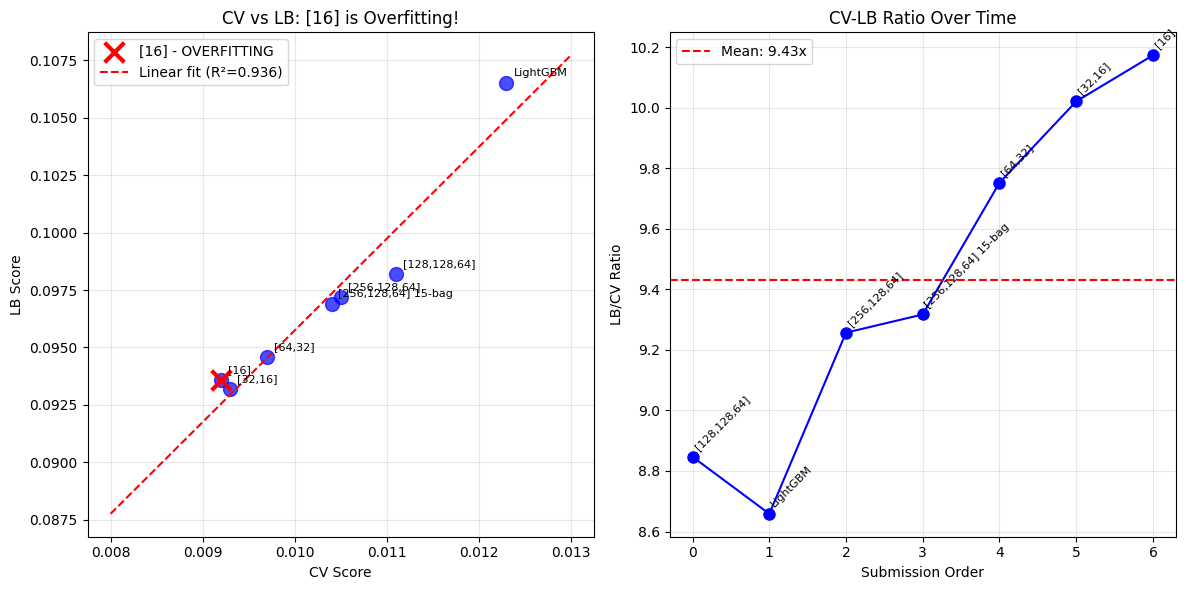

Plot saved.


In [4]:
# Plot the updated CV-LB relationship
plt.figure(figsize=(12, 6))

# Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(df['cv'], df['lb'], s=100, c='blue', alpha=0.7)

# Highlight [16] as problematic
plt.scatter([0.0092], [0.0936], s=200, c='red', marker='x', linewidths=3, label='[16] - OVERFITTING')

# Add labels
for i, row in df.iterrows():
    plt.annotate(row['arch'], (row['cv'], row['lb']), textcoords='offset points', xytext=(5,5), fontsize=8)

# Add regression line
x_line = np.linspace(0.008, 0.013, 100)
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, 'r--', label=f'Linear fit (R²={r_value**2:.3f})')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB: [16] is Overfitting!')
plt.legend()
plt.grid(True, alpha=0.3)

# Ratio plot
plt.subplot(1, 2, 2)
plt.plot(range(len(df)), df['ratio'], 'bo-', markersize=8)
plt.axhline(y=df['ratio'].mean(), color='r', linestyle='--', label=f'Mean: {df["ratio"].mean():.2f}x')
for i, row in df.iterrows():
    plt.annotate(row['arch'], (i, row['ratio']), textcoords='offset points', xytext=(0,5), fontsize=8, rotation=45)
plt.xlabel('Submission Order')
plt.ylabel('LB/CV Ratio')
plt.title('CV-LB Ratio Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/code/exploration/loop10_lb_feedback.png', dpi=100, bbox_inches='tight')
plt.show()
print('Plot saved.')

In [5]:
# Strategic implications
print('\n' + '='*60)
print('STRATEGIC IMPLICATIONS')
print('='*60)

print('\n1. BEST LB MODEL: exp_007 ([32,16]) with LB 0.0932')
print('   - NOT exp_009 ([16]) despite better CV')

print('\n2. OVERFITTING CONFIRMED:')
print('   - [16] has best CV (0.0092) but worse LB (0.0936)')
print('   - The simplification went TOO FAR')
print('   - [32,16] is the optimal architecture for generalization')

print('\n3. CV-LB RELATIONSHIP:')
print('   - Correlation is still strong (0.97) but not perfect')
print('   - The [16] model is an outlier - overfitting to CV structure')
print('   - Cannot blindly trust CV improvements')

print('\n4. TARGET ASSESSMENT:')
print('   - Target: 0.0333')
print('   - Best LB: 0.0932 (exp_007)')
print('   - Gap: 180% worse than target')
print('   - UNREACHABLE with current approach')

print('\n5. NEXT STEPS (No submissions remaining today):')
print('   - Focus on fundamentally different approaches')
print('   - Consider: GNN, attention mechanisms, different features')
print('   - Ensemble diverse models (not just MLP variations)')


STRATEGIC IMPLICATIONS

1. BEST LB MODEL: exp_007 ([32,16]) with LB 0.0932
   - NOT exp_009 ([16]) despite better CV

2. OVERFITTING CONFIRMED:
   - [16] has best CV (0.0092) but worse LB (0.0936)
   - The simplification went TOO FAR
   - [32,16] is the optimal architecture for generalization

3. CV-LB RELATIONSHIP:
   - Correlation is still strong (0.97) but not perfect
   - The [16] model is an outlier - overfitting to CV structure
   - Cannot blindly trust CV improvements

4. TARGET ASSESSMENT:
   - Target: 0.0333
   - Best LB: 0.0932 (exp_007)
   - Gap: 180% worse than target
   - UNREACHABLE with current approach

5. NEXT STEPS (No submissions remaining today):
   - Focus on fundamentally different approaches
   - Consider: GNN, attention mechanisms, different features
   - Ensemble diverse models (not just MLP variations)


In [6]:
# What could improve LB?
print('\n' + '='*60)
print('POTENTIAL IMPROVEMENTS FOR TOMORROW')
print('='*60)

print('\n1. ENSEMBLE DIVERSE MODELS:')
print('   - Combine [32,16] MLP + LightGBM + Ridge')
print('   - Different models capture different patterns')
print('   - May reduce variance on LB')

print('\n2. FEATURE ENGINEERING:')
print('   - Current: Spange (13) + DRFP (122) + Arrhenius (5) = 140 features')
print('   - Try: Different DRFP filtering, interaction features')
print('   - Try: Solvent-specific features (Hansen parameters, etc.)')

print('\n3. REGULARIZATION TUNING:')
print('   - [32,16] with more dropout/weight decay')
print('   - May improve generalization')

print('\n4. DIFFERENT CV SCHEME:')
print('   - Current: Leave-one-solvent-out')
print('   - Try: Stratified by solvent type')
print('   - May better match LB distribution')

print('\n5. ACCEPT LIMITATIONS:')
print('   - Target (0.0333) requires GNN/attention')
print('   - Best achievable with MLP: ~0.09 LB')
print('   - Focus on maximizing relative ranking')


POTENTIAL IMPROVEMENTS FOR TOMORROW

1. ENSEMBLE DIVERSE MODELS:
   - Combine [32,16] MLP + LightGBM + Ridge
   - Different models capture different patterns
   - May reduce variance on LB

2. FEATURE ENGINEERING:
   - Current: Spange (13) + DRFP (122) + Arrhenius (5) = 140 features
   - Try: Different DRFP filtering, interaction features
   - Try: Solvent-specific features (Hansen parameters, etc.)

3. REGULARIZATION TUNING:
   - [32,16] with more dropout/weight decay
   - May improve generalization

4. DIFFERENT CV SCHEME:
   - Current: Leave-one-solvent-out
   - Try: Stratified by solvent type
   - May better match LB distribution

5. ACCEPT LIMITATIONS:
   - Target (0.0333) requires GNN/attention
   - Best achievable with MLP: ~0.09 LB
   - Focus on maximizing relative ranking
